# 0 - Using pycoco to Generate Lightcurves
___
CoCo is a tool to generate Core-Collapse Supernova lightcurves using spectrophotometric templates, based on a sample of 30 Stripped-Envelope SNe. This set of notebooks (and module) basically assume that you have this installed - if not, head to [https://github.com/UoS-SNe/CoCo](https://github.com/UoS-SNe/CoCo) and follow the instructions.

## Brief description of operation
___
![flowchart](data/pycoco_flowchart.png)

## Prerequisites
___
There are three environment variables you need to have set before `pycoco` will work properly:

* `COCO_ROOT_DIR` (my default is `${HOME}/Code/CoCo/`)
* `SFD_DIR` (this points to dust maps for extincting simulations - my default is `${HOME}/data/Dust/sfddata-master/` - see https://github.com/kbarbary/sfdmap for detailed instructions, including where to download the maps)
* `LSST_THROUGHPUTS`  (my default is `${HOME}/projects/LSST/throughputs` - this needs to point at a clone of [https://github.com/lsst/throughputs](https://github.com/lsst/throughputs)) 


The `CoCo` cython simulation module also needs to be built. Run:

```python setup.py build_ext --inplace```

_note_: `COCO_ROOT_DIR` should also be in your path 

This creates the module `pyCoCo` (_note caps_) which I'll be importing as `pccsims`. 

## Testing `pycoco`

Assuming you have done the above, you can check the install by running the bundled tests:

In [ ]:
import pycoco as pcc

pcc.testing.runtests()

# Simulating Lightcurves
___
This section deals with simulating lightcurves - hopefully you have the bundled fits, or have run your own (if not, now is a good time to head over to [1 - pycoco calling CoCo.ipynb](1 - pycoco calling CoCo.ipynb)).

Below is a minumum working example. Following on from that is a more realistic treatment using a subset of LSST OpSim simulations.

In [7]:
%matplotlib inline

from matplotlib import pyplot as plt

import os
import numpy as np

import pycoco as pcc
import pyCoCo as pccsim

## Set up the Simulator Generator
___

In [2]:
fltPath = pcc.utils.b(pcc.defaults._default_filter_dir_path)
rootPath = pcc.utils.b(pcc.defaults._default_coco_dir_path)
print(fltPath)
print(rootPath)

info = pcc.classes.InfoClass()
info.load()

coco = pccsim.pyCoCo(fltPath, rootPath)

b'/Users/szymon/Projects/CoCo/data/filters/'
b'/Users/szymon/Projects/CoCo/'


# Simple LC
___
## Set Params

In [10]:
snname = "SN1998bw"             ## Name of the SN Template to use
mjdmax = 50.                    ## Time that peak set by specphase() occurs at
mjd_obs = np.arange(0.,105.,5.) ## 5 Day Cadence, single filter

filter_name = "LSST_g"                                                       ## The filters must be a np array of
filter_obs = np.array([pcc.utils.b(filter_name) for observation in mjd_obs]) ## bytestrings
                                                                             
z_sim = info.get_sn_info(snname)["z_distmod"]

absmag_offset = 0.0
EBV_MW = 0.0
EBV_host = 0.0
R_v = 3.1

## Generate Lightcurve

In [11]:
flux, flux_err = coco.simulate(pcc.utils.b(snname),
                               z_sim, 
                               absmag_offset, 
                               EBV_MW, EBV_host, R_v,
                               mjdmax, mjd_obs,
                               filter_obs)

## Load in and Inspect

In [12]:
sn_sim = pcc.classes.SNClass("SN1998bw")
sn_sim.load_phot(phot_table = pcc.utils.simulate_out_to_ap_table(mjd_obs, flux, flux_err, filter_obs))
sn_sim.phot.data

OrderedDict([('LSST_g', <Table length=31>
                MJD          flux       flux_err filter
              float64      float64      float64   str6 
              ------- ----------------- -------- ------
                -50.0 2.29290191677e-14      0.0 LSST_g
                -45.0 2.25548356074e-14      0.0 LSST_g
                -40.0 2.21620182764e-14      0.0 LSST_g
                -35.0 2.17467612135e-14      0.0 LSST_g
                -30.0 2.13047785151e-14      0.0 LSST_g
                -25.0 2.08313243668e-14      0.0 LSST_g
                -20.0  2.0321257275e-14      0.0 LSST_g
                -15.0 1.97691659874e-14      0.0 LSST_g
                -10.0 1.91695763401e-14      0.0 LSST_g
                 -5.0 1.85172572424e-14      0.0 LSST_g
                  ...               ...      ...    ...
                 55.0 7.10220664096e-15      0.0 LSST_g
                 60.0 6.17851301083e-15      0.0 LSST_g
                 65.0 5.32715115312e-15      0.0 LSST_g
      

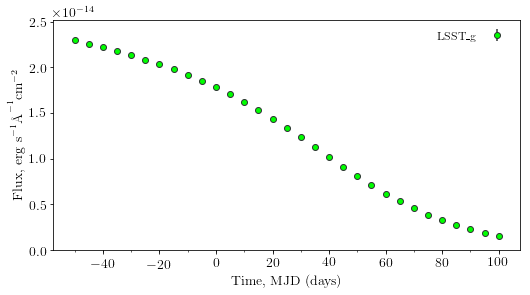

In [13]:
sn_sim.plot_lc(multiplot = False)

## Let's Compare

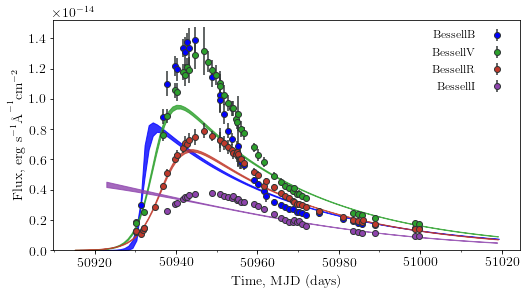

In [9]:
sn = pcc.classes.SNClass(snname)
sn.load_phot(verbose=False)
sn.get_lcfit(os.path.join(pcc.defaults._default_recon_dir_path, snname + ".dat"))

sn.plot_lc(multiplot=False)

In [ ]:
mjdmax_bessellV = pcc.utils.get_mjdmax(sn, "BessellV")

fig = sn_sim.plot_lc(multiplot = False, return_figure=True)

ax = fig.add_subplot(111)
ax.errorbar(sn.phot.data["BessellV"]["MJD"] - mjdmax_bessellV + 50, sn.phot.data["BessellV"]["flux"],
            yerr = sn.phot.data["BessellV"]["flux_err"], capsize = 0, fmt = 'o',
            color = pcc.colours.hex["BessellV"], ecolor = pcc.colours.hex['batman'], mec = pcc.colours.hex["batman"],
            zorder = -99, label=r"$\rm{BessellV}$")
ax.errorbar(sn.phot.data["BessellB"]["MJD"] - mjdmax_bessellV + 50, sn.phot.data["BessellB"]["flux"],
            yerr = sn.phot.data["BessellB"]["flux_err"], capsize = 0, fmt = 'o',
            color = pcc.colours.hex["BessellB"], ecolor = pcc.colours.hex['batman'], mec = pcc.colours.hex["batman"],
            zorder = -99, label=r"$\rm{BessellB}$")
legend = ax.legend(loc = 'upper right', scatterpoints = 1, markerfirst = False,
                                              numpoints = 1, frameon = False, bbox_to_anchor=(1., 1.),
                                              fontsize = 12.)

# LSST-like LC
___

Rather than making a single band light curve that is sampled every 5 days, you probably want to simulate a realistic cadence, in more than one band. Luckily, there is an example for that too.

## Deep Drilling Fields

In [ ]:
from astropy.table import Table

ddf_opsimpath = "data/ddf_opsimdf_fieldID2786_minion.csv"
# ddf_opsimpath = "data/ddf_opsimdf_fieldID2786_fakerolling.csv"

t = Table.read(ddf_opsimpath)

In [ ]:
t[:5]

In [ ]:
w = np.where(t["night"] < 356)

t_y1 = t[w] ## just consider the first year

In [ ]:
snname = "SN1998bw"             ## Name of the SN Template to use
mjdmax = 90                     ## Time that peak set by specphase() occurs at, relative to the first observation
mjd_obs = t_y1["expMJD"]-np.nanmin(t_y1["expMJD"])
                                                                                        ## The filters must be a np array of
filter_obs = np.array([pcc.utils.b("LSST_"+filter_name) for filter_name in t_y1["filter"]]) ## bytestrings
                                                                             
z_sim = info.get_sn_info(snname)["z_distmod"] ## simulate at the same redshift as before

absmag_offset = 0.0
EBV_MW = 0.0
EBV_host = 0.0
R_v = 3.1

In [ ]:
flux, flux_err = coco.simulate(pcc.utils.b(snname),
                               z_sim, 
                               absmag_offset, 
                               EBV_MW, EBV_host, R_v,
                               mjdmax, mjd_obs,
                               filter_obs)

In [ ]:
sn_sim = pcc.classes.SNClass("SN1998bw")
sn_sim.load_phot(phot_table = pcc.utils.simulate_out_to_ap_table(mjd_obs, flux, flux_err, filter_obs))
sn_sim.phot.data

In [ ]:
sn_sim.plot_lc()

## Wide-Fast-Deep Fields
___

In [ ]:
from astropy.table import Table

ddf_opsimpath = "data/wfd_opsimdf_fieldID1000_minion.csv"
# ddf_opsimpath = "data/wfd_opsimdf_fieldID1000_fakerolling.csv"


t = Table.read(ddf_opsimpath)

In [ ]:
t[:5]

In [ ]:
w = np.where(t["night"] < 356)

t_y1 = t[w] ## just consider the first year

In [ ]:
snname = "SN1998bw"             ## Name of the SN Template to use
mjdmax = 90                     ## Time that peak set by specphase() occurs at, relative to the first observation
mjd_obs = t_y1["expMJD"]-np.nanmin(t_y1["expMJD"])
                                                                                        ## The filters must be a np array of
filter_obs = np.array([pcc.utils.b("LSST_"+filter_name) for filter_name in t_y1["filter"]]) ## bytestrings
                                                                             
z_sim = info.get_sn_info(snname)["z_distmod"] ## simulate at the same redshift as before

absmag_offset = 0.0
EBV_MW = 0.0
EBV_host = 0.0
R_v = 3.1

In [ ]:
flux, flux_err = coco.simulate(pcc.utils.b(snname),
                               z_sim, 
                               absmag_offset, 
                               EBV_MW, EBV_host, R_v,
                               mjdmax, mjd_obs,
                               filter_obs)

In [ ]:
sn_sim = pcc.classes.SNClass("SN1998bw")
sn_sim.load_phot(phot_table = pcc.utils.simulate_out_to_ap_table(mjd_obs, flux, flux_err, filter_obs))
sn_sim.phot.data

In [ ]:
sn_sim.plot_lc()

## Exporting
____

You can take a bit more of a look at the PhotometryClass and SNClass in [./3 - pycoco_SNClass.ipynb](./3 - pycoco_SNClass.ipynb)[]()